In [61]:
import numpy as np  
import matplotlib.pylab as plt
import pickle
from sklearn.decomposition import PCA
import gpflow

In [62]:
def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)


def modelLoad(nRankMax, snap_ID):
    GPmodel = modelDir + 'GP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + 'PCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))

    # print(GPmodel)
    return GPm, PCAm

def GPy_predict(gpmodel, para_array):
    m1p = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(gpmodel, pcamodel, para_array):
    para_array = np.array(para_array)
    # print(para_array)
    para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
    if len(para_array.shape) == 1:
        # print(para_array_rescaled)
        W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def MGemu(Om, ns, s8, fR0, n, z):
    if (z==0):
        GPm, PCAm = modelLoad(nRankMax, 99)
        Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    else:
        snap_idx_nearest = (np.abs(z_all - z)).argmin()
        if (z > z_all[snap_idx_nearest]): 
            snap_ID_z1 = snap_idx_nearest - 1    
        else:
            snap_ID_z1 = snap_idx_nearest 
        snap_ID_z2 = snap_ID_z1 + 1

        GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
        Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
        z1 = z_all[snap_ID_z1]

        GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
        Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
        z2 = z_all[snap_ID_z2]
        
        # print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        # print('Linear interpolating for snapshots ', 'for z1= '+ str(snap_ID_z1), 'and z2= '+ str(snap_ID_z2))
        
        Pk_interp = np.zeros_like(Pk_z1)
        Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp


In [63]:
nRankMax = 16
# del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 


dataDir = "./Data/Emulator213bins/" ## Data folder
modelDir = "./Models/" ## Data folder

az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(99) + '.txt'

loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
z_all = az[:, 1]

lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims.txt')

In [64]:
nbody_1 = np.loadtxt('./Data/Nbody_validation/ratios_19.txt')
nbody_2 = np.loadtxt('./Data/Nbody_validation/ratios_22.txt')
nbody_3 = np.loadtxt('./Data/Nbody_validation/ratios_27.txt')
nbody_4 = np.loadtxt('./Data/Nbody_validation/ratios_29.txt')
nbody_5 = np.loadtxt('./Data/Nbody_validation/ratios_33.txt')
nbody_6 = np.loadtxt('./Data/Nbody_validation/ratios_35.txt')
nbody_7 = np.loadtxt('./Data/Nbody_validation/ratios_36.txt')
nbody_8 = np.loadtxt('./Data/Nbody_validation/ratios_38.txt')

nbody_pk = np.array([nbody_1, nbody_2, nbody_3, nbody_4, nbody_5, nbody_6, nbody_7, nbody_8])


In [65]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
n_f=1

fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6

z_array = [1.016539373193011, 0.806909104243328, 0.505668030951772, 0.398366114391517, 0.200981514826109, 0.109319263502801, 0.064946498060623, 0.0]

In [66]:
snap_id_array = [0, 3, 5, 7] #range(8)


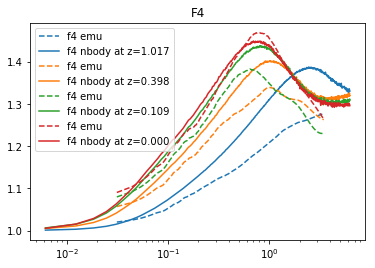

In [67]:
plt.figure(1)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='f4 emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 1], label='f4 nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F4')
plt.legend()
plt.show()

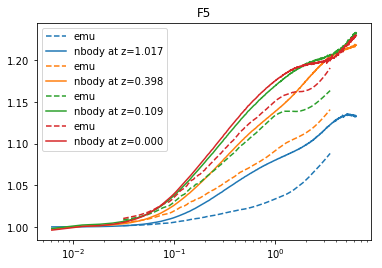

In [68]:
plt.figure(2)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 2], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F5')
plt.legend()
plt.show()

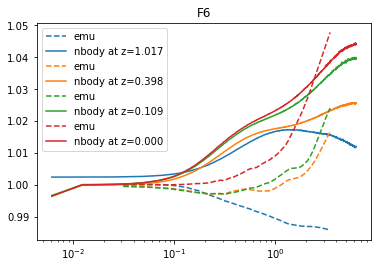

In [69]:
plt.figure(3)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 3], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F6')
plt.legend()
plt.show()